In [15]:
import torch
import sys
import pyro

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

from pooledQTL import deconvolve, beta_model, gaussian_model, io_utils, asb_data

from importlib import reload

from pathlib import Path

fdr_threshold = 0.05
device = "cuda:0" if torch.cuda.is_available() else "cpu"
use_structured_guide = True # performs much better

results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/HNRNPK")

 Load input RNA allelic counts. We should know have good depth for both biological replicates. 

In [16]:
basedir = "/gpfs/commons/home/mschertzer/asb_model/220708_all_ipsc_ip/allelic/"
input_files = [ basedir + "input-rep1_allelic.out", # this is bio rep 1 (two sequencing runs combined)
               basedir + "input-rep2_allelic.out"]

IP_files = [ basedir + "hnrnpk-rep1_allelic.out", 
            basedir + "hnrnpk-rep2_allelic.out" ]

input_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in input_files ]
input_counts[0].head()

,contig,position,variantID,refAllele,altAllele,refCount,altCount,totalCount
0,chr1,16071,rs541172944,G,A,26,0,26
1,chr1,16141,rs529651976,C,T,52,2,54
2,chr1,16280,.,T,C,29,0,29
3,chr1,128747,rs565117739,A,C,10,1,11
4,chr1,137978,rs529853750,G,A,520,1,521


There is some weirdness where one rsID maps to two positions. deconvolve.merge will just filter these out. 

Observed genotype data (after running StrandScript)

In [17]:
geno = io_utils.loadGenotypes('/gpfs/commons/home/phalmos/genotypes/CIRMlines_flipped.vcf', 
                     maxlines = None, 
                     posterior = False).rename(columns = {"SNP" : "variantID"})
geno.head()

,position,contig,variantID,refAllele,altAllele,CW30274-1-1194512543_CW30274-1-1194512543,CW30454-1-1194512472_CW30454-1-1194512472,CW30421-1-1194512512_CW30421-1-1194512512,CW70372-1-1194512488_CW70372-1-1194512488,CW40201-1-1194512480_CW40201-1-1194512480,CW30525-1-1194512464_CW30525-1-1194512464,CW30190-1-1194512504_CW30190-1-1194512504,CW30108-1-1194512496_CW30108-1-1194512496,CW30154-1-1194512551_CW30154-1-1194512551,CW70179-1-1194512535_CW70179-1-1194512535,CW70142-1-1194512527_CW70142-1-1194512527
rs3131972,752721,chr1,rs3131972,G,A,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5
rs11240777,798959,chr1,rs11240777,G,A,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5
rs4970383,838555,chr1,rs4970383,N,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rs4475691,846808,chr1,rs4475691,C,T,0.5,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.5,0.5,1.0
rs13302982,861808,chr1,rs13302982,G,A,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


# Deconvolution

sum(w)=1.001391 ideally would be 1


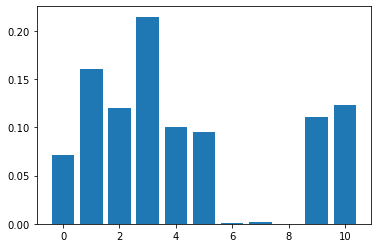

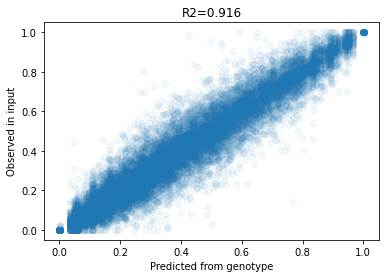

sum(w)=0.998289 ideally would be 1


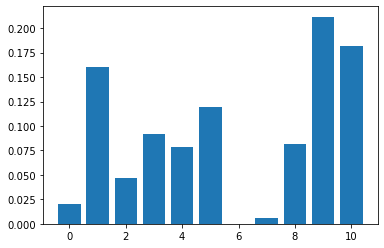

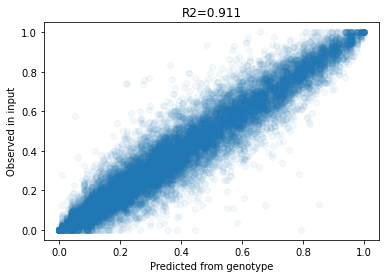

In [18]:
w = [ deconvolve.deconvolve(geno, inp) for inp in input_counts ]

In [19]:
props = pd.DataFrame(w).transpose()
props.columns = ["rep1","rep2"]
props["line"] = geno.columns[5:16]
props.iloc[:,[2,0,1]].to_csv(results_dir / "deconv.tsv", index = False, sep = "\t")

props

,rep1,rep2,line
0,0.071627,0.019891,CW30274-1-1194512543_CW30274-1-1194512543
1,0.160709,0.159960,CW30454-1-1194512472_CW30454-1-1194512472
2,0.120467,0.047090,CW30421-1-1194512512_CW30421-1-1194512512
3,0.214985,0.092138,CW70372-1-1194512488_CW70372-1-1194512488
4,0.100975,0.078045,CW40201-1-1194512480_CW40201-1-1194512480
5,0.094822,0.119431,CW30525-1-1194512464_CW30525-1-1194512464
6,0.001167,0.000000,CW30190-1-1194512504_CW30190-1-1194512504
7,0.002068,0.006409,CW30108-1-1194512496_CW30108-1-1194512496
8,0.000000,0.082046,CW30154-1-1194512551_CW30154-1-1194512551
9,0.110731,0.211748,CW70179-1-1194512535_CW70179-1-1194512535


# Load and check imputed genotypes

In [20]:
sanger_feather = Path("/gpfs/commons/home/daknowles/pooledRBPs/genotypes/sanger.feather")
sanger = pd.read_feather(sanger_feather)
del sanger["index"]

In [22]:
sanger = sanger[sanger.SNP != "."]
sanger = sanger[~sanger.SNP.duplicated()] # this removes triallelic SNPs, which I don't think we know how to handle anyway

cols = list(sanger.columns)
cols[0], cols[1] = cols[1], cols[0]
sanger = sanger.loc[:,cols]

# Load IP count data and join with input and genotype

In [23]:
IP_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in IP_files ]

With the new data the counts are similiar for both bio replicates:

In [24]:
[ g.totalCount.sum()/1e6 for g in IP_counts ]

[551.655497, 342.291892]

In [25]:
[ g.totalCount.sum()/1e6 for g in input_counts ]

[453.871685, 439.627239]

Joining genotype and input allelic counts


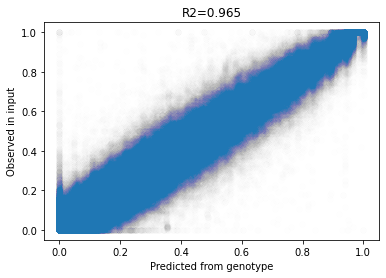

Joining genotype+input with IP allelic counts
Joining genotype and input allelic counts


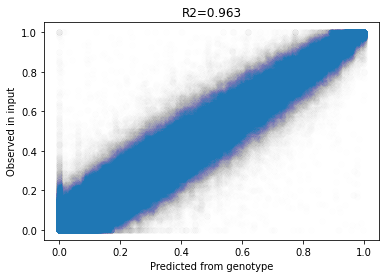

Joining genotype+input with IP allelic counts


In [26]:
merged = {} 
dat_sub = {}
for rep_index in range(2):
    merged[rep_index],dat_sub[rep_index] = deconvolve.merge_geno_and_counts(sanger, 
                                                                            input_counts[rep_index], 
                                                                            IP_counts[rep_index], 
                                                                            w[rep_index], 
                                                                            plot = True)

# Run beta models

This can't handle replicates. 

Learned hyperparameters: {'input_conc': 78.84437561035156, 'input_count_conc': 239.46194458007812, 'IP_conc': 72.65687561035156, 'IP_count_conc': 407.5784606933594}


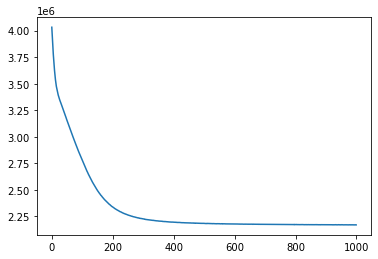

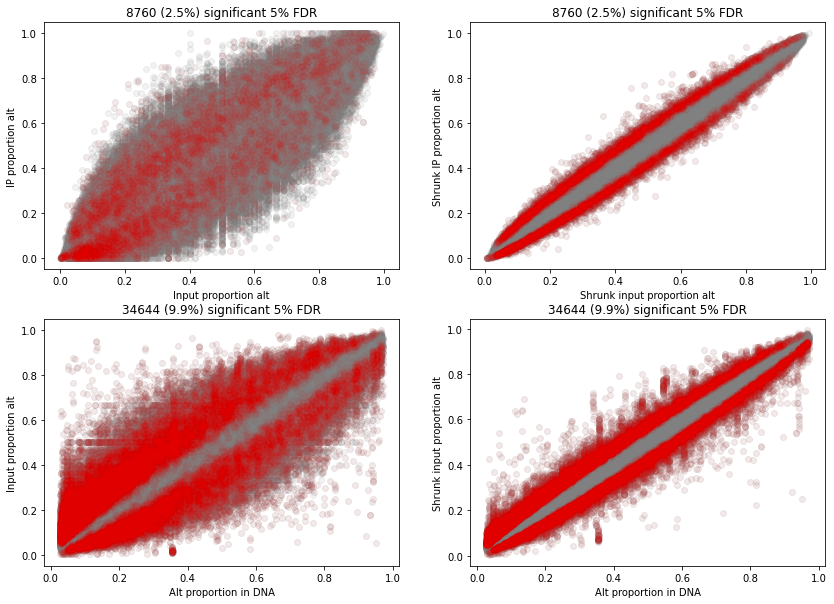

Learned hyperparameters: {'input_conc': 75.25276947021484, 'input_count_conc': 213.97935485839844, 'IP_conc': 64.87577819824219, 'IP_count_conc': 384.0181579589844}


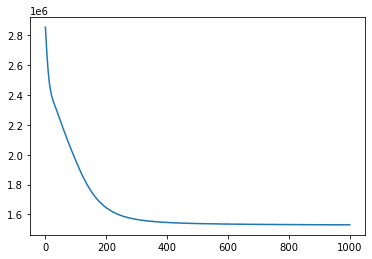

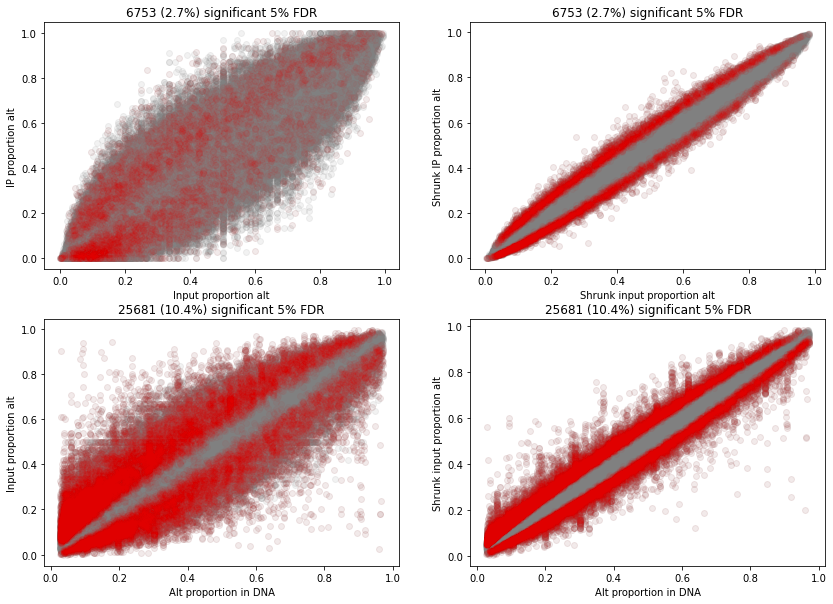

In [27]:
reload(beta_model)

for rep_index in range(len(merged)):

    results = beta_model.fit_plot_and_save(dat_sub[rep_index], 
                                             results_dir / ("beta" 
                                                            + ("_struct" if use_structured_guide else "") 
                                                            + ("_rep%i.tsv.gz" % rep_index)),
                                             use_structured_guide = use_structured_guide,
                                             fdr_threshold = fdr_threshold, 
                                             iterations = 1000,
                                             device = device)
    

# Gaussian model without replicates

Could also run this with the mean field guide. 

Learned hyperparameters: {'ase_scale': 0.18291203677654266, 'input_count_conc': 158.10223388671875, 'asb_scale': 0.19663351774215698, 'IP_count_conc': 148.68495178222656, 'ase_t_df': 3.9364707469940186, 'asb_t_df': 8.165337562561035}


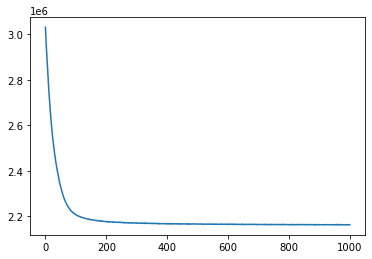

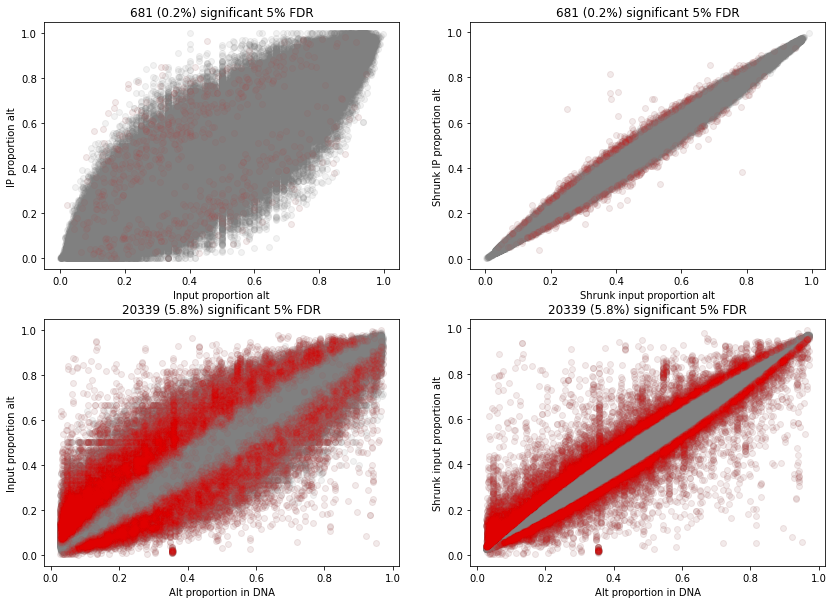

Learned hyperparameters: {'ase_scale': 0.18618609011173248, 'input_count_conc': 144.5665740966797, 'asb_scale': 0.20947742462158203, 'IP_count_conc': 132.32676696777344, 'ase_t_df': 3.8540472984313965, 'asb_t_df': 8.324873924255371}


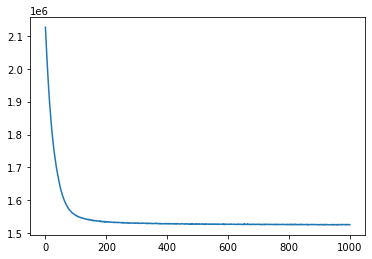

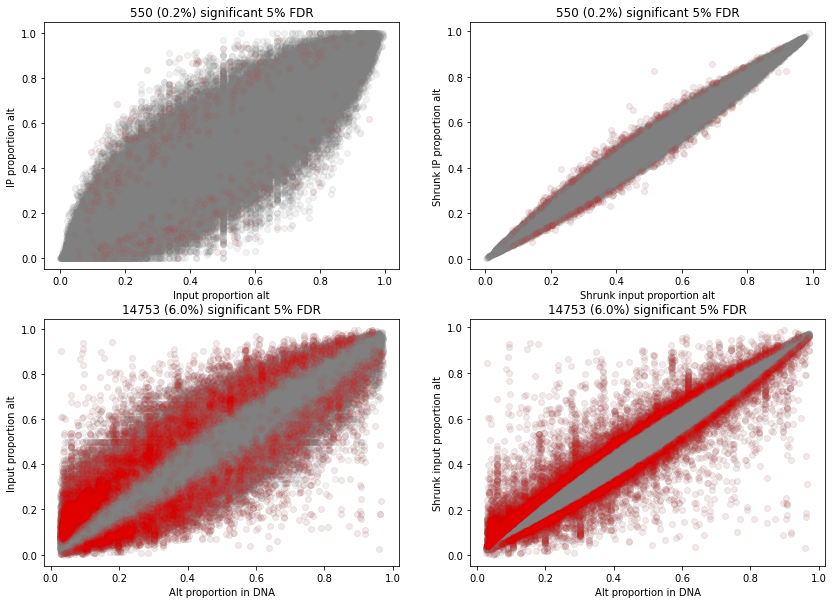

In [79]:
reload(beta_model)
reload(gaussian_model)
for rep_index in range(len(merged)):

    results = gaussian_model.fit_plot_and_save(dat_sub[rep_index], 
                                             results_dir / ("normal" 
                                                            + ("_struct" if use_structured_guide else "") 
                                                            + ("_rep%i.tsv.gz" % rep_index)),
                                             use_structured_guide = use_structured_guide,
                                             fdr_threshold = fdr_threshold, 
                                             iterations = 1000,
                                             device = device)
    

# Replicates model

In [ ]:
#reload(gaussian_model)
rep_results = gaussian_model.fit_replicates_plot_and_save(dat_sub, 
                                             results_dir / ("rep" 
                                                            + ("_struct" if use_structured_guide else "") 
                                                            + "_results.tsv.gz"),
                                             use_structured_guide = use_structured_guide,
                                             fdr_threshold = fdr_threshold, 
                                             iterations = 1000,
                                             device = device)

In [64]:
for assay in ["input","IP"]:
    for allele in ["alt","ref","total"]: 
        rep_results["%sCount_%s" % (allele, assay)] = rep_results["%sCount_%s_%i" % (allele, assay, 1)] + \
            rep_results["%sCount_%s_%i" % (allele, assay, 2)]
    rep_results["%s_ratio" % assay] = rep_results["altCount_%s" % assay] / rep_results["totalCount_%s" % assay]
    for rep_idx in [1,2]:
        rep_results["shrunk_%s_ratio_%i" % (assay,rep_idx)] = scipy.special.logit(rep_results["pred_ratio_%i" % rep_idx]) + rep_results.ase_loc + (
            0 if (assay=="input") else rep_results.asb_loc)

Plot combined counts for reps 1 and 2. 

Text(0.5, 1.0, 'Both reps 1391 (0.4%) significant 5% FDR')

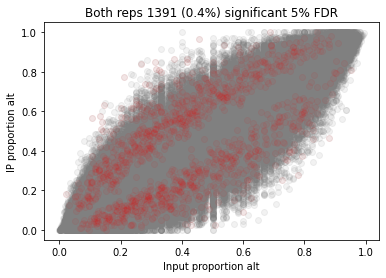

In [73]:
plt.scatter(dat_here.input_ratio, dat_here.IP_ratio,alpha=0.1, color="gray")
dat_ss = dat_here[dat_here.asb_q < fdr_threshold]
plt.scatter(dat_ss.input_ratio, dat_ss.IP_ratio,alpha=0.05, color = "red")
plt.xlabel("Input proportion alt"); plt.ylabel("IP proportion alt")
plt.title('Both reps %i (%.1f%%) significant %.0f%% FDR' % ((dat_here.asb_q < fdr_threshold).sum(), 
                                                  100. * (dat_here.asb_q < fdr_threshold).mean(), 
                                                  fdr_threshold*100))

Plots for individual replicates, but showing significance for the joint model. 

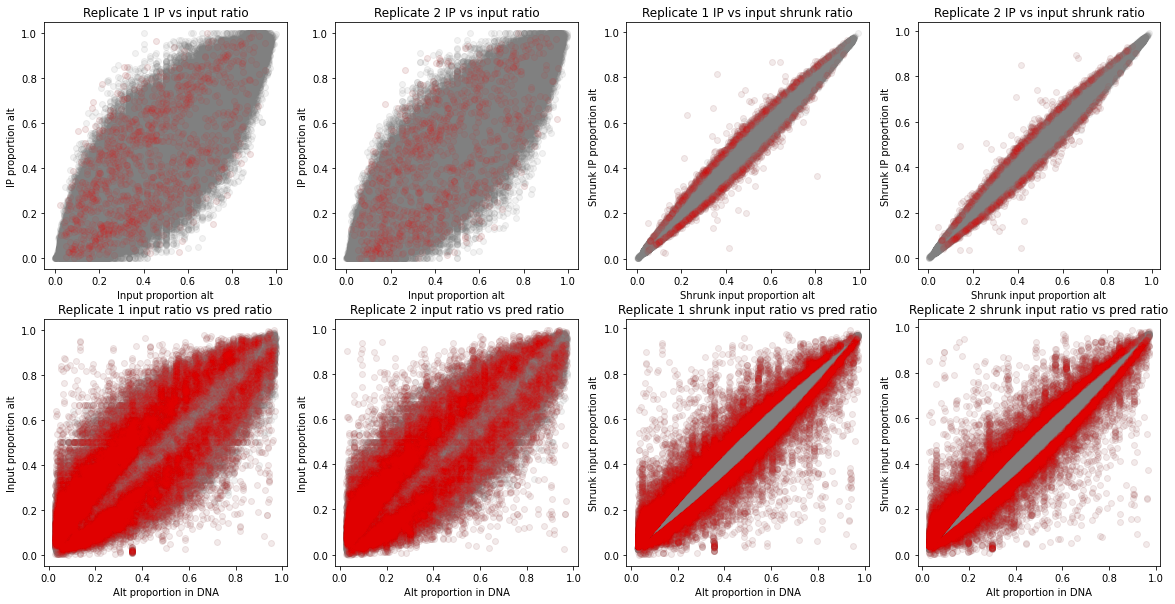

In [76]:
logistic = lambda g: 1./(1.+np.exp(-g))

plt.figure(figsize=(20,10))

for rep_idx in [1,2]:
    
    dat_here = rep_results[rep_results["totalCount_input_%i" % rep_idx] > 0]
    
    plt.subplot(2,4,rep_idx)
    plt.scatter(dat_here["input_ratio_%i" % rep_idx], dat_here["IP_ratio_%i" % rep_idx],alpha=0.1, color="gray")
    dat_ss = dat_here[dat_here.asb_q < fdr_threshold]
    plt.scatter(dat_ss["input_ratio_%i" % rep_idx], dat_ss["IP_ratio_%i" % rep_idx],alpha=0.05, color = "red")
    plt.xlabel("Input proportion alt"); plt.ylabel("IP proportion alt")
    plt.title('Replicate %i IP vs input ratio' % rep_idx)

    plt.subplot(2,4,2+rep_idx)
    plt.scatter( logistic(dat_here["shrunk_input_ratio_%i" % rep_idx]), logistic(dat_here["shrunk_IP_ratio_%i" % rep_idx]),alpha=0.1, color="gray")
    dat_ss = dat_here[dat_here.asb_q < fdr_threshold]
    plt.scatter(logistic(dat_ss["shrunk_input_ratio_%i" % rep_idx]), logistic(dat_ss["shrunk_IP_ratio_%i" % rep_idx]),alpha=0.03, color = "red")
    plt.xlabel("Shrunk input proportion alt"); plt.ylabel("Shrunk IP proportion alt")
    plt.title('Replicate %i IP vs input shrunk ratio' % rep_idx)

    plt.subplot(2,4,4+rep_idx)
    plt.scatter( dat_here["pred_ratio_%i" % rep_idx], dat_here["input_ratio_%i" % rep_idx],alpha=0.1, color="gray")
    dat_ss = dat_here[dat_here.ase_q < fdr_threshold]
    plt.scatter( dat_ss["pred_ratio_%i" % rep_idx], dat_ss["input_ratio_%i" % rep_idx],alpha=0.03, color = "red")
    plt.xlabel("Alt proportion in DNA"); plt.ylabel("Input proportion alt")
    plt.title('Replicate %i input ratio vs pred ratio' % rep_idx)

    plt.subplot(2,4,6+rep_idx)
    plt.scatter( dat_here["pred_ratio_%i" % rep_idx], logistic(dat_here["shrunk_input_ratio_%i" % rep_idx]),alpha=0.1, color="gray")
    dat_ss = dat_here[dat_here.ase_q < fdr_threshold]
    plt.scatter( dat_ss["pred_ratio_%i" % rep_idx], logistic(dat_ss["shrunk_input_ratio_%i" % rep_idx]),alpha=0.03, color = "red")
    plt.xlabel("Alt proportion in DNA"); plt.ylabel("Shrunk input proportion alt")
    plt.title('Replicate %i shrunk input ratio vs pred ratio' % rep_idx)


In [75]:
rep_results

,contig,position_hg19,variantID,refAllele,altAllele,position,refCount_input_1,altCount_input_1,totalCount_input_1,input_ratio_1,...,altCount_IP,refCount_IP,totalCount_IP,IP_ratio,shrunk_input_ratio,shrunk_IP_ratio,shrunk_input_ratio_1,shrunk_input_ratio_2,shrunk_IP_ratio_1,shrunk_IP_ratio_2
0,chr10,294953,rs1017361,A,G,249013,18,109,127,0.858268,...,34,2,36,0.944444,2.360132,2.407049,2.360132,-inf,2.407049,-inf
1,chr10,320954,rs10903832,A,G,275014,98,24,122,0.196721,...,6,30,36,0.166667,-1.421873,-1.399966,-1.421873,-inf,-1.399966,-inf
2,chr10,325134,rs12357593,C,T,279194,10,4,14,0.285714,...,5,33,38,0.131579,-1.358743,-1.425559,-1.358743,-inf,-1.425559,-inf
3,chr10,327780,rs7908298,C,T,281840,11,7,18,0.388889,...,14,20,34,0.411765,-0.339653,-0.298221,-0.339653,-inf,-0.298221,-inf
4,chr10,347752,rs7918643,C,T,301812,12,9,21,0.428571,...,10,42,52,0.192308,-0.914372,-1.052445,-0.914372,-inf,-1.052445,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385766,chr9,140656514,rs7032719,T,C,137762062,0,0,0,0.000000,...,10,22,32,0.312500,-inf,-inf,-inf,-0.313368,-inf,-0.340235
385767,chr9,140709605,rs67116066,A,G,137815153,0,0,0,0.000000,...,5,72,77,0.064935,-inf,-inf,-inf,-2.163874,-inf,-2.123441
385768,chr9,140709647,rs72766964,A,G,137815195,0,0,0,0.000000,...,5,94,99,0.050505,-inf,-inf,-inf,-2.257456,-inf,-2.330899
385769,chr9,140866826,rs12352971,G,T,137972374,0,0,0,0.000000,...,22,43,65,0.338462,-inf,-inf,-inf,-1.282179,-inf,-1.010658
